In [1]:
import numpy as np
import xarray as xr
import xrft as xf
import dask.array as dsar
import os.path as op
import scipy.fftpack as fft

from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def synthetic_field(N=512, dL=1., amp=1e1, s=-3.):
    """
    Generate a synthetic series of size N by N 
    with a spectral slope of s.
    """

    k = fft.fftshift(fft.fftfreq(N, dL))
    l = fft.fftshift(fft.fftfreq(N, dL))
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2+ll**2)

    ########
    # amplitude
    ########
    r_kl = np.ma.masked_invalid(np.sqrt(amp*.5*(np.pi)**(-1)*K**(s-1.))).filled(0.)
    #r = np.ma.masked_invalid(np.abs(k)**(-slope/2.)).filled(0.)
    ########
    # phase
    ########
    phi = np.zeros((N, N))
    
    N_2 = int(N/2)
    phi_upper_right = 2.*np.pi*np.random.random((N_2-1, 
                                                 N_2-1)) - np.pi
    phi[N_2+1:,N_2+1:] = phi_upper_right.copy()
    phi[1:N_2, 1:N_2] = -phi_upper_right[::-1, ::-1].copy()


    phi_upper_left = 2.*np.pi*np.random.random((N_2-1, 
                                                N_2-1)) - np.pi
    phi[N_2+1:,1:N_2] = phi_upper_left.copy()
    phi[1:N_2, N_2+1:] = -phi_upper_left[::-1, ::-1].copy()


    phi_upper_middle = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[N_2:, N_2] = phi_upper_middle.copy()
    phi[1:N_2, N_2] = -phi_upper_middle[1:][::-1].copy()


    phi_right_middle = 2.*np.pi*np.random.random(N_2-1) - np.pi
    phi[N_2, N_2+1:] = phi_right_middle.copy()
    phi[N_2, 1:N_2] = -phi_right_middle[::-1].copy()


    phi_edge_upperleft = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[N_2:, 0] = phi_edge_upperleft.copy()
    phi[1:N_2, 0] = -phi_edge_upperleft[1:][::-1].copy()


    phi_bot_right = 2.*np.pi*np.random.random(N_2) - np.pi
    phi[0, N_2:] = phi_bot_right.copy()
    phi[0, 1:N_2] = -phi_bot_right[1:][::-1].copy()


    phi_corner_leftbot = 2.*np.pi*np.random.random() - np.pi


#     print(phi[N/2-1,N-1], phi[N/2+1,1])
#     print(phi[N/2+1,N/2+1], phi[N/2-1,N/2-1])


#     phi[:N/2, :] = -np.rot90(np.rot90(phi[N/2:, :]))
#     phi[:N/2, :] = -phi[N/2:, :][::-1,::-1]
#     i, j = 25, 40
#     print(phi[N/2+j,N/2+i], -phi[N/2-j,N/2-i])

    for i in range(1, N_2):
        for j in range(1, N_2):
            assert (phi[N_2+j, N_2+i] == -phi[N_2-j, N_2-i])
        
    for i in range(1, N_2):
        for j in range(1, N_2):
            assert (phi[N_2+j, N_2-i] == -phi[N_2-j, N_2+i])
        
    for i in range(1, N_2):
        assert (phi[N_2, N-i] == -phi[N_2, i])
        assert (phi[N-i, N_2] == -phi[i, N_2])
        assert (phi[N-i, 0] == -phi[i, 0])
        assert (phi[0, i] == -phi[0, N-i])
    #########
    # complex fourier amplitudes
    #########
    #a = r + 1j*th
    F_theta = r_kl * np.exp(1j * phi)
    
    # check that symmetry of FT is satisfied
    #np.testing.assert_almost_equal(a[1:N/2], a[-1:-N/2:-1].conj())

    theta = fft.ifft2(fft.ifftshift(F_theta))
    return np.real(theta) 

In [3]:
theta = synthetic_field(N=512, s=-3.)
print(theta.shape)
theta = xr.DataArray(theta, dims=['k', 'l'],
            coords={'k':range(512), 'l':range(512)})
# theta = dsar.from_array(theta, chunks=(32, 32))
theta

(512, 512)


/Users/uchidatakaya/anaconda/envs/xrft/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in power
  from ipykernel import kernelapp as app


<xarray.DataArray (k: 512, l: 512)>
array([[ 1.444068,  1.447595,  1.403313, ...,  1.680273,  1.615998,  1.498588],
       [ 1.587043,  1.547181,  1.51214 , ...,  1.765096,  1.701764,  1.638299],
       [ 1.657837,  1.610558,  1.575774, ...,  1.815839,  1.790492,  1.736478],
       ..., 
       [ 1.477077,  1.420807,  1.385132, ...,  1.603291,  1.559585,  1.52638 ],
       [ 1.467398,  1.406257,  1.390299, ...,  1.600949,  1.546954,  1.504083],
       [ 1.430439,  1.391629,  1.36768 , ...,  1.620153,  1.538358,  1.457467]])
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * l        (l) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...

In [4]:
iso_f = xf.isotropic_spectrum(theta, remove_mean=True, 
                  density=True)

/Users/uchidatakaya/Documents/Python/xrft/xrft/xrft.py:266: RuntimeWarning: invalid value encountered in true_divide
  weights=K.ravel()) / area
/Users/uchidatakaya/Documents/Python/xrft/xrft/xrft.py:270: RuntimeWarning: invalid value encountered in true_divide
  / area


In [5]:
iso_f

<xarray.DataArray (freq_r: 65)>
array([           nan,   2.550221e+02,   4.903986e+00,   8.391019e-01,
         2.988403e-01,   1.379649e-01,   7.498363e-02,   4.502427e-02,
         2.927883e-02,   2.008844e-02,   1.435778e-02,   1.067054e-02,
         8.117941e-03,   6.309782e-03,   5.005780e-03,   4.044307e-03,
         3.314148e-03,   2.744339e-03,   2.299836e-03,   1.946939e-03,
         1.662942e-03,   1.431469e-03,   1.240042e-03,   1.080280e-03,
         9.469672e-04,   8.359031e-04,   7.415839e-04,   6.604993e-04,
         5.908240e-04,   5.309626e-04,   4.790399e-04,   4.332895e-04,
         3.932416e-04,   3.581096e-04,   3.269543e-04,   2.993571e-04,
         2.748810e-04,   2.529597e-04,   2.331994e-04,   2.154656e-04,
         1.995924e-04,   1.851549e-04,   1.720689e-04,   1.601456e-04,
         1.492893e-04,   1.394817e-04,   1.304702e-04,   1.222226e-04,
         1.146581e-04,   1.076999e-04,   1.013231e-04,   9.542842e-05,
         8.997212e-05,   8.492804e-05,   8.02

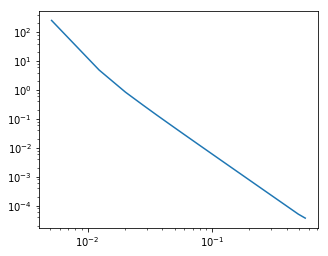

In [6]:
fig = plt.figure(figsize=(11,4))

ax1 = fig.add_subplot(121)
ax1.loglog(iso_f.freq_r,iso_f)

In [8]:
y_fit, a, b = xf.fit_loglog(iso_f.freq_r.values[4:],
                            iso_f.values[4:])

In [9]:
a

-3.0092969574999602